# Installing require package




In [1]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.0 MB/s eta 0:00:00



# Mounting Google Drive 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Change directory

In [3]:
cd /content/gdrive/MyDrive/frontYardMonitoring/yolov7

/content/gdrive/MyDrive/frontYardMonitoring/yolov7


# Setting up helper code for inference 

In [4]:
import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

# Filtering YOLOv7 detection objects to only 'Person'

In [5]:
#list of classes to ignore, focus on 'person' class only
classes_to_filter = ['tv', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'potted plant', 'bed', 'dining table', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'] 

opt  = {
    
    "weights": "weights/yolov7.pt", # Path to weights file default weights are for nano model
    "yaml"   : "data/coco.yaml",
    "img-size": 640, # default image size
    "conf-thres": 0.25, # confidence threshold for inference.
    "iou-thres" : 0.45, # NMS IoU threshold for inference.
    "device" : '0',  # device to run our model i.e. 0 or 0,1,2,3 or cpu
    "classes" : classes_to_filter  # list of classes to filter or None

}

# Create function to display Optical Flow & check for large magnitudes

In [6]:
def draw_flow(img, flow, step):
    global warningIntensity 

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int) #plotting out the grid dots (510 dots)
    fx, fy = flow[y,x].T #(size fx is 510, fy is also 510)
         
    #setting up the magnitude size that counts as 'large'
    magThreshold = 30

    #increase the excessive motion intensity bar if exists large optical flow
    if any(i > magThreshold and i != 0 for i in fx):
        if warningIntensity < 256:
            warningIntensity += 25
            if warningIntensity > 255: 
                warningIntensity = 255
    
    elif any(i > magThreshold and i != 0 for i in fy):
        if warningIntensity < 256:
            warningIntensity += 25
            if warningIntensity > 255: 
                warningIntensity = 255
                
    elif any(i > magThreshold/2 and i != 0 for i in fx):
        if warningIntensity < 256:
            warningIntensity += 22
            if warningIntensity > 255: 
                warningIntensity = 255
    
    elif any(i > magThreshold/2 and i != 0 for i in fy):
        if warningIntensity < 256:
            warningIntensity += 22
            if warningIntensity > 255: 
                warningIntensity = 255            

    #decrease the excessive motion intensity bar if no large optical flow            
    else:
        if warningIntensity > 0:
            warningIntensity -= 5
            
    #drawing out the optical flow 
    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0),2)

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 3, (0, 255, 0), -1)

    return img_bgr

# Enter Video Path of video to test

In [7]:
video_path = '/content/gdrive/MyDrive/frontYardMonitoring/fypStuff/testVideos/fighting_1.mp4'

# Initializing video object
video = cv2.VideoCapture(video_path)

# Defining the region of interest (polygon) 


In [8]:
%matplotlib ipympl
from google.colab import output
output.enable_custom_widget_manager()

click to specify the points


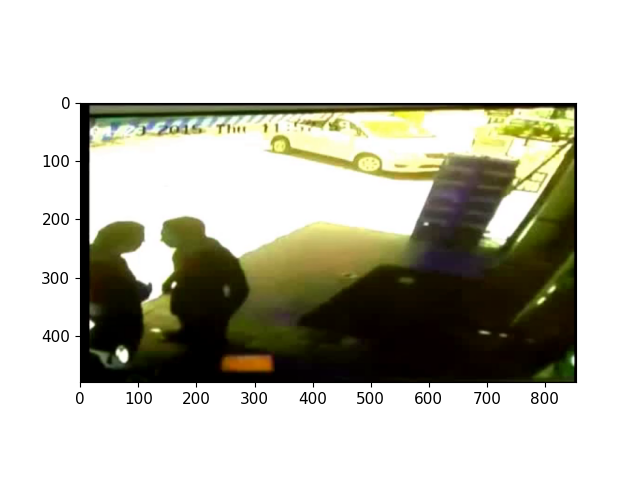

Point 1
405 188


Point 2
831 262


Point 3
836 467


Point 4
16 470


Point 5
11 381


Point 6
402 193


polygon points recorded 



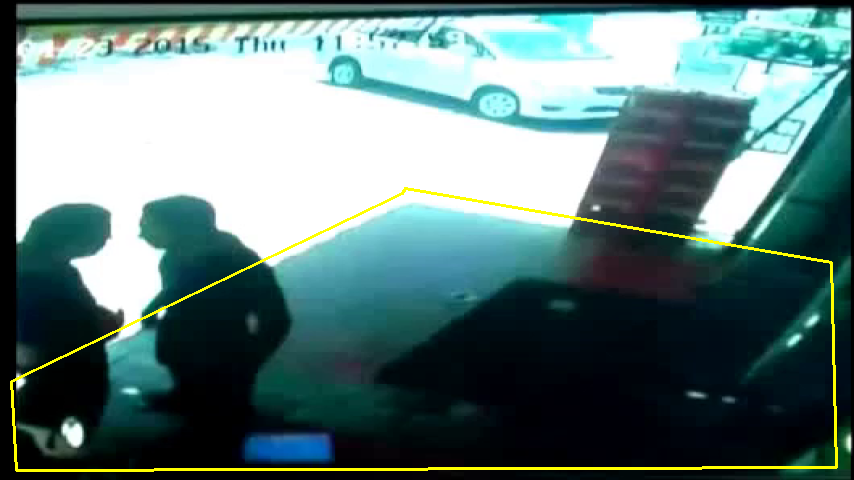

In [9]:
#defining the region of interest

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import math

ret, img = video.read()
img = cv2.resize(img, (854, 480), interpolation = cv2.INTER_AREA)

fig, ax = plt.subplots()
imgplot = plt.imshow(img)
coords = [] 
global num
pointCount = 1

print('click to specify the points')
pointCount = 1

def onclick(event):
    ix, iy = event.xdata, event.ydata
    plt.plot(event.xdata, event.ydata, 'o', markersize = 15, color = 'yellow')
    global pointCount
    print("Point", pointCount)
    pointCount = pointCount + 1
    print(int(ix), int(iy))
    print("\n")

    global coords
    coords.append((ix, iy))

    if len(coords) > 1:
    
      if (abs(coords[0][0]-ix)) < 50 and (abs(coords[0][1]-iy)) < 50:
          fig.canvas.mpl_disconnect(cid)
        
          print("polygon points recorded \n")

          # show the polygon in image
          coords = np.array([coords], np.int32)
          coords = coords.reshape((-1,1,2))
          cv2_imshow(cv2.polylines(img,[coords],True,(0,255,255), 2))

    return

cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Intrusion and violence detection, with warning messages

In [10]:
#Video information
video = cv2.VideoCapture(video_path)

fps = video.get(cv2.CAP_PROP_FPS)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialzing object for writing video output
output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20 , (854+500, 480))  #(w + 500, h)
torch.cuda.empty_cache()
# Initializing model and setting it for inference
with torch.no_grad():
  weights, imgsz = opt['weights'], opt['img-size']
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride
  imgsz = check_img_size(imgsz+500, s=stride)  # check img_size
  if half:
    model.half()

  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:

      classes.append(names.index(class_name))

  if classes:
    
    classes = [i for i in range(len(names)) if i not in classes]

  #initially no humans
  humanPresence = False
  numOfHuman = 0
  potentialIntrusion = False

  #### getting the first frame 
  suc, prev = video.read()
  prev = cv2.resize(prev, (854, 480), interpolation = cv2.INTER_AREA) 
  prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

  warningIntensity = 0
  ####

  for j in range(nframes - 1):

      ret, img0 = video.read()

      #### getting current frame
      img0 = cv2.resize(img0, (854, 480), interpolation = cv2.INTER_AREA)
      img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

      flow = cv2.calcOpticalFlowFarneback(prevgray, img0, None, 0.5, 3, 15, 3, 5, 1.2, 0)  #comparing previous and current frame 
      prevgray = img0 #set previous frame equal current frame, for next iteration

      img0 = draw_flow(img0, flow, 30)
      ####

      #displaying the roi   
      cv2.polylines(img0,[coords],True,(0,255,255), 2)

      ####setting up the analysis board
      board = cv2.imread("/content/gdrive/MyDrive/frontYardMonitoring/fypStuff/board.png")
      board = cv2.resize(board, (500, img0.shape[0]))
      img0 = cv2.hconcat([img0, board])
      #####

      if ret:
        img = letterbox(img0, imgsz, stride=stride)[0]
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
          img = img.unsqueeze(0)

        ##########################################################
        img0 = cv2.rectangle(img0, (img0.shape[1] - 499, 1), (img0.shape[1], img0.shape[0]), (255,255,255), -1)

        img0 = cv2.putText(img0, (str(numOfHuman) + " human(s)"), (860, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                     1, (0,0,0), 3, cv2.LINE_AA)
        
        if humanPresence is False: 
          cv2.rectangle(img0, pt1=(1051, 320), pt2=(1109, 380), color=(0,255,0), thickness=-1)
          riskStatus = 'SAFE'
          img0 = cv2.putText(img0, 'checking for intruder...', (860, 100), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0,0,0), 2, cv2.LINE_AA)
        
        if humanPresence is True and potentialIntrusion is False:
          img0 = cv2.putText(img0, 'checking for intruder...', (860, 100), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0,0,0), 2, cv2.LINE_AA)

          cv2.rectangle(img0, pt1=(1051, 320), pt2=(1109, 380), color=(0,255,0), thickness=-1)
          riskStatus = 'SAFE'
        
        if potentialIntrusion is True: 
          img0 = cv2.putText(img0, 'POTENTIAL INTRUSION!', (860, 100), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0,0,0), 3)

          cv2.rectangle(img0, pt1=(1111, 320), pt2=(1169, 380), color=(0,255,255), thickness=-1)
          riskStatus = 'ALERT'
        ##########################################################

        #####
        cv2.line(img0, (854, 130), (1354, 130), color=(0,0,0), thickness=2) 
        cv2.line(img0, (854, 295), (1354, 295), color=(0,0,0), thickness=2)
        #####

        ############################## excessive motion warning
        cv2.putText(img0, 'Motion intensity:', (860, 170), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, warningIntensity), 3)
        
        cv2.rectangle(img0, pt1=(860, 190), pt2=(1115, 217), color=(0,0,0), thickness=5)
        
        if warningIntensity < 128:
            cv2.line(img0, (987, 190), (987, 217), color=(0,0,255), thickness=2) 
            cv2.putText(img0, 'checking excessive motion...', (860, 270), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        
        cv2.rectangle(img0, pt1=(860, 191), pt2=(860 + warningIntensity, 216), color=(0, 0, warningIntensity), thickness= -1)
        
        if warningIntensity > 128: 
          if potentialIntrusion is True:
            cv2.putText(img0, 'POTENTIAL VIOLENCE!', (860, 270), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
            cv2.rectangle(img0, pt1=(1111, 320), pt2=(1169, 380), color=(255,255,255), thickness=-1)
            cv2.rectangle(img0, pt1=(1171, 320), pt2=(1229, 380), color=(0,0,255), thickness=-1)
            riskStatus = 'DANGER'
        ##############################

        ############################## risk level: 
        cv2.putText(img0, 'Risk Level: ', (860, 360), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
        cv2.rectangle(img0, pt1=(1050, 320), pt2=(1230, 380), color=(0,0,0), thickness=10)
        cv2.line(img0, (1110, 320), (1110, 380), color=(0,0,0), thickness=10)
        cv2.line(img0, (1170, 320), (1170, 380), color=(0,0,0), thickness=10)

        cv2.putText(img0, riskStatus, (1050, 430), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
        ##############################

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment= False)[0]

        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        t2 = time_synchronized()
        for i, det in enumerate(pred):

          print("Processing frame " f"{j+1}/{nframes} \n")

          s = ''
          s += '%gx%g ' % img.shape[2:]  # print string
          gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
          if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

            for c in det[:, -1].unique():
              n = (det[:, -1] == c).sum()  # detections per class
              s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

              #testing
              numOfHuman = s[s.find(' ') + 1]

              if numOfHuman is '0': 
                humanPresence = False;  
              else: 
                humanPresence = True;             

              #GETTING THE BOTTOM CENTER POINTS OF THE PERSON OBJECT(S)
              print("Human count: " + str(numOfHuman))
              for i in range(int(numOfHuman)):
                print("Person " + str(i + 1) + " coordinates:")
                
                bottomCenterXPoint = int(det[:,:4][i][2].item() - ((det[:,:4][i][2].item() - det[:,:4][i][0].item()) / 2))
                bottomCenterYPoint = int(det[:,:4][i][3].item())
                print("bottom center point: " + str(bottomCenterXPoint) + ", " + str(bottomCenterYPoint))
                print("\n")

                dist = cv2.pointPolygonTest(coords, (bottomCenterXPoint, bottomCenterYPoint), False)
                print('polygon test result: ')
                print(dist)

                if dist == 1.0:
                  potentialIntrusion = True
                  cv2.circle(img0, (bottomCenterXPoint, bottomCenterYPoint), 8, (0, 0, 255), -1)

                else: 
                  potentialIntrusion = False
                  cv2.circle(img0, (bottomCenterXPoint, bottomCenterYPoint), 8, (255, 255, 255), -1)

            for *xyxy, conf, cls in reversed(det):

              label = f'{names[int(cls)]} {conf:.2f}'
              plot_one_box(xyxy, img0, label=label, color=[0,0,0], line_thickness=3)
        
        output.write(img0)
      else:
        break
    

output.release()
video.release()

<>:169: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:169: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-10-d877d7d4216f>:169: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if numOfHuman is '0':


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Streaming output truncated to the last 5000 lines.
bottom center point: 342, 390


polygon test result: 
1.0
Processing frame 640/1083 

Human count: 1
Person 1 coordinates:
bottom center point: 344, 389


polygon test result: 
1.0
Processing frame 641/1083 

Human count: 1
Person 1 coordinates:
bottom center point: 340, 390


polygon test result: 
1.0
Processing frame 642/1083 

Human count: 1
Person 1 coordinates:
bottom center point: 333, 393


polygon test result: 
1.0
Processing frame 643/1083 

Human count: 1
Person 1 coordinates:
bottom center point: 341, 391


polygon test result: 
1.0
Processing frame 644/1083 

Human count: 1
Person 1 coordinates:
bottom center point: 340, 390


polygon test result: 
1.0
Processing frame 645/1083 

Human count: 1
Person 1 coordinates:
bottom center point: 360, 393


polygon test result: 
1.0
Processing frame 646/1083 

Human count: 1
Person 1 coordinates:
bottom center point: 362, 392


polygon test result: 
1.0
Processing frame 647/1083 

Hu

# Display compressed-video

Video will be in the output folder, pls delete the result_compressed.mp4 file before next video inference

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/gdrive/MyDrive/frontYardMonitoring/yolov7/output.mp4'

# Compressed video path
compressed_path = "/content/gdrive/MyDrive/frontYardMonitoring/output/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)